[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/monografia_modelos/blob/main/00_combinacion_dataset.ipynb)


In [1]:
try:
    import google.colab 
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/repos-especializacion-UdeA/monografia_modelos/refs/heads/main/init.py
    from init import init; init(force_download=False)
except ImportError:
    print("Ejecucion del notebook en entorno local")

Ejecucion del notebook en entorno local


# Prepraración del dataset Ninapro DB1 - Almacenamiento de las señales como matrices de numpy

## Descripción corta del dataset

*Ninapro* ([link](https://ninapro.hevs.ch/)) es un base de datos publica destinada a fomentar la investigación de aprendizaje automático en manos humanas, robóticas y protésicas. *Ninapro* posee 10 datasets que incluyen 180 adquisiciones de datos de sujetos sanos y con amputacion transradial (debajo del codo). 

En este caso especifico, se seleccionó el dataset [DB1](https://ninapro.hevs.ch/instructions/DB1.html) el cual se describe brevemente en la siguiente tabla:

| Columna                     | Descripción                                                   | Ejemplo                |
|:----------------------------|:--------------------------------------------------------------|:-----------------------|
| `Subject`                   | Sujeto                                                        | 01                     |
| `Hand`                      | Mano                                                          | Intact                 |
| `Handedness`                | Lateralidad                                                   | Right / Left           |
| `Gender`                    | Genero                                                        | Male / Female          |
| `Age`                       | Edad                                                          | 31                     |
| `Height`                    | Altura                                                        | 170                    |
| `Weight`                    | Peso                                                          | 75                     |
| `zip files`                 | Archivos con las adquisición de los datos                     | s1.zip                 |

En DB1, existen 27 archivos comprimidos (`S1.zip`, `S2.zip`, ..., `S27.zip`) con la adquisición de datos de los sujetos. Cada archivo contiene un directorio con tres archivos MAT (Matlab) con el siguiente formado `Sx_Ay_Ez.mat` donde:
* **`x`**: Numero del sujeto (entre 1 y 27).
* **`y`**: Adquisición (A1: Primera adquisición).
* **`z`**: Numero del ejercicio: 1, 2 o 3.

Como nuestro trabajo solo se va a centrar en las posturas del ejercicio uno, solo nos va a interesar los archivos MAT de la forma `Sx_A1_E1.mat` de cada uno de los 27 sujetos.

## Objetivo a desarrollar

> Obtener del dataset crudo los datos, combinarlos y realizar una transformación simple para hacerlos aptos para el entrenamiento de los modelos a emplear.

## Resumen del proceso realizado

El procedimiento se resume en los siguientes pasos:
1. Combinación de los datasets del ejercicio 1 (`Sx_A1_E3.mat`) de los 27 sujetos de prueba en un unico dataset.
2. Conocimiento de la forma básica del dataset para identificar las columnas asociadas a los sensores de electromiografia, el numero de repeticiones y la postura realizada; los cuales representan los datos de interes.
3. Extracción las columnas de interes, realizar una visualización rapida de las señales y comprender el contexto de uso de estas.
4. Realición del preproceamiento de las señales adquiridas el cual se resume en:
   * **Filtrado**: Eliminar el ruido que pueda tener la señal. El filtrado se hara para toda la base de datos.
   * **Enventanado**: Tomar porciones de la señal para hacer un analisis localizado. Es importante tener en cuenta que solo se seleccionó la información asociada a los 10 primeros sujetos de los 27 que tiene la base de datos.
5. Extracción de caracteristicas sobre cada segmento de la señal (ventana) con el fin de reducir la cantidad de información para alimentar los modelos. 
6. A partir la base de datos que contiene los vectores caracteristicos de las ventanas de tiempo de la información de los 10 sujetos seleccionadas se generó un archivo CSV para las etapas siguientes del proceso de analitica de datos.

A continuación se trabaja sobre las plantillas que el profesor nos facilito durante el curso.

## 1. Librerias y configuraciones previas


In [2]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.


In [5]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal

# Bliblioteca de archivos
# ==============================================================================
import requests
from tqdm import tqdm
import os
import zipfile
import sys

# Biblioteca libemg
# ==============================================================================
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

## 2. Funciones

In [6]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
# from utils.funciones1 import multiple_plot
# from utils.funciones2 import test_hola, graficar_medida, graficar_medida2, filter_signal, \
#                             segmentar_data_base, aplanar_data_base, aplanar_ventana, \
#                             rms_value, mav_value, features_data_base

## 3. Variables de entorno

La lista de directorios se muestra a continuación:
* Directorio de trabajo
* Directorio de datos
  * Directorio de datos crudos

In [52]:
ROOT_DIR =  './'
DATA_DIR =  ROOT_DIR + 'local/data/'
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)    
RAW_DATA_DIR = DATA_DIR + 'raw'
if not os.path.exists(RAW_DATA_DIR):
    os.makedirs(RAW_DATA_DIR)
RAW_DATA_DIR_NPY = DATA_DIR + 'raw_numpy'
if not os.path.exists(RAW_DATA_DIR_NPY):
    os.makedirs(RAW_DATA_DIR_NPY)

print("Directorio de trabajo:", ROOT_DIR)
print("Directorio de datos:", DATA_DIR)
print("Directorio de datos crudos:", RAW_DATA_DIR)
print("Directorio de datos crudos (numpy):", RAW_DATA_DIR_NPY)

Directorio de trabajo: ./
Directorio de datos: ./local/data/
Directorio de datos crudos: ./local/data/raw
Directorio de datos crudos (numpy): ./local/data/raw_numpy


## 3. Carga y preprocesamiento del dataset original

### Visualización de un solo archivo MAT

Con el fin de conocer un poco lo que contiene un solo MAT vamos a realizar los siguientes procedimientos.

En nuestro analisis, solo nos va a interesar los datos de las columnas:
* **`emg`**: Señales EMG superficiales tomadas de los 10 electronos.
* **`rerepetition`**: Repetición de la postura de la mano (ejercicio) realizado. Cada postura se repetira 10 veces.
* **`restimulus`**: Postura manual (ejercicio) realizada.

### Caso de las señales EMG

Dado que los registros de la base de datos son señales (secuencias temporales), es necesario llevar a cabo una etapa adicional de **procesamiento digital de señales** con el fin de garantizar que los datos de entrada al modelo sean adecuados. En esta fase se realizan pasos clave; como la segmentación de la señal y la extracción de características mediante transformaciones. En nuestro caso se realizaron basicamente dos pasos en esta etapa:
1. Filtrado.
2. Segmentación.
3. Extracción de caracteristicas.

### 3.1. Carga de datos

In [40]:
archivos_raw = os.listdir(RAW_DATA_DIR)
print("Archivos en el directorio de datos crudos:")
# Listar los archivos en el directorio de datos crudos
for archivo in archivos_raw:
    print(' -> '+ archivo)

Archivos en el directorio de datos crudos:
 -> S10_A1_E3_emg.csv
 -> S10_A1_E3_exercise.csv
 -> S10_A1_E3_repetition.csv
 -> S10_A1_E3_rerepetition.csv
 -> S10_A1_E3_restimulus.csv
 -> S10_A1_E3_stimulus.csv
 -> S10_A1_E3_subject.csv
 -> S11_A1_E3_emg.csv
 -> S11_A1_E3_exercise.csv
 -> S11_A1_E3_repetition.csv
 -> S11_A1_E3_rerepetition.csv
 -> S11_A1_E3_restimulus.csv
 -> S11_A1_E3_stimulus.csv
 -> S11_A1_E3_subject.csv
 -> S12_A1_E3_emg.csv
 -> S12_A1_E3_exercise.csv
 -> S12_A1_E3_repetition.csv
 -> S12_A1_E3_rerepetition.csv
 -> S12_A1_E3_restimulus.csv
 -> S12_A1_E3_stimulus.csv
 -> S12_A1_E3_subject.csv
 -> S13_A1_E3_emg.csv
 -> S13_A1_E3_exercise.csv
 -> S13_A1_E3_repetition.csv
 -> S13_A1_E3_rerepetition.csv
 -> S13_A1_E3_restimulus.csv
 -> S13_A1_E3_stimulus.csv
 -> S13_A1_E3_subject.csv
 -> S14_A1_E3_emg.csv
 -> S14_A1_E3_exercise.csv
 -> S14_A1_E3_repetition.csv
 -> S14_A1_E3_rerepetition.csv
 -> S14_A1_E3_restimulus.csv
 -> S14_A1_E3_stimulus.csv
 -> S14_A1_E3_subject.csv
 -

### 3.2. Combinación de los archivos

In [ ]:
NUM_SUBJECTS = 27

dataset_folder = RAW_DATA_DIR                                    # Carpeta donde están los archivos csv crudos
subjects_values = [str(i) for i in range(1, NUM_SUBJECTS + 1)]   # Lista de sujetos a filtrar (s1 a s27)
actions_values = ['1']                                           # Adquisicion 1
exercises_values = ['3']                                         # Ejercicio tipo 3 (agarres)

#### 3.2.1. Datos EMG

**Forma**: `S{x}_A{y}_E{z}_emg.cvs`

In [ ]:
# Definir los filtros RegEx para extraer metadatos del nombre de archivo
emg_filters_emg = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_emg.csv", values = exercises_values, description='exercise')
]

emg_odh = OfflineDataHandler()
emg_odh.get_data(folder_location = dataset_folder, regex_filters = emg_filters_emg, delimiter=",")

27 data files fetched out of 189 files.


#### 3.2.2. Datos restimulus

**Forma**: `S{x}_A{y}_E{z}_restimulus.cvs`

In [43]:
regex_filters_restimulus = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_restimulus.csv", values = exercises_values, description='exercise')  
]

restimulus_odh = OfflineDataHandler()
restimulus_odh.get_data(folder_location = dataset_folder, regex_filters = regex_filters_restimulus, delimiter=",")

27 data files fetched out of 189 files.


#### 3.2.3. Datos rerepetition

**Forma**: `S{x}_A{y}_E{z}_rerepetition.cvs`

In [44]:
rerepetition_regex_filters = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_rerepetition.csv", values = exercises_values, description='exercise')   
]

rerepetition_odh = OfflineDataHandler()
rerepetition_odh.get_data(folder_location = dataset_folder, regex_filters = rerepetition_regex_filters, delimiter=",")

27 data files fetched out of 189 files.


### 3.2.4. Carga de los registros de todos los usuarios

Se cargan todas las posturas asociadas a los ejercios de hagarre (ejercicio 3).

In [ ]:
END_INDEX = 27
sub_index = list(range(END_INDEX))
emg_data = emg_odh.isolate_data(key="subject", values = sub_index).data
restimulus_data = restimulus_odh.isolate_data(key="subject", values = sub_index).data
rerepetition_data = rerepetition_odh.isolate_data(key="subject", values = sub_index).data

data_ex3 = []
for i in sub_index:
    # Se elimina la primera fila
    emg_data[i] = emg_data[i][1:]
    restimulus_data[i] = restimulus_data[i][1:]
    rerepetition_data[i] = rerepetition_data[i][1:]    
    print(f"Se agregan {emg_data[i].shape[0]} registros del sujeto {i + 1} al conjunto de datos")
    data_i = X_total = np.concatenate((emg_data[i], restimulus_data[i], rerepetition_data[i]), axis=1)
    data_ex3.append(data_i)

Se agregan 214236 registros del sujeto 1 al conjunto de datos
Se agregan 228111 registros del sujeto 2 al conjunto de datos
Se agregan 216799 registros del sujeto 3 al conjunto de datos
Se agregan 212872 registros del sujeto 4 al conjunto de datos
Se agregan 217794 registros del sujeto 5 al conjunto de datos
Se agregan 232710 registros del sujeto 6 al conjunto de datos
Se agregan 212871 registros del sujeto 7 al conjunto de datos
Se agregan 227980 registros del sujeto 8 al conjunto de datos
Se agregan 220750 registros del sujeto 9 al conjunto de datos
Se agregan 222991 registros del sujeto 10 al conjunto de datos
Se agregan 227493 registros del sujeto 11 al conjunto de datos
Se agregan 224161 registros del sujeto 12 al conjunto de datos
Se agregan 228483 registros del sujeto 13 al conjunto de datos
Se agregan 222276 registros del sujeto 14 al conjunto de datos
Se agregan 221977 registros del sujeto 15 al conjunto de datos
Se agregan 224028 registros del sujeto 16 al conjunto de datos
S

#### 3.2.5. Inspección de los datos cargados

Para verificar los datos cargados vamos a mirar un elemento del array 

In [49]:
SUBJECT_INDEX = 0 # Sujeto 1
data_ex3[SUBJECT_INDEX].shape

(214236, 12)

Segun lo anterior, la forma de la matriz de datos asociada a cada usuario es la siguiente:

`[ emg | restimulus | rerepetition ] = [ 0:9 | 10 | 11 ]`

Donde cada una de las columnas tiene:
* **`emg`**: Señales emg
* **`restimulus`**: 1 - 23 (El reposo se toma como 0)
* **`rerepetition`**: 1 - 10

Para verificar que los datos fueron correctamente cargados se graficas los datos correspondientes al usuario 1 (indice 0)

In [50]:
sub_index = 0
emg, restimulus, rerepetition = data_ex3[sub_index][:,:10], data_ex3[sub_index][:,10], data_ex3[sub_index][:,11]

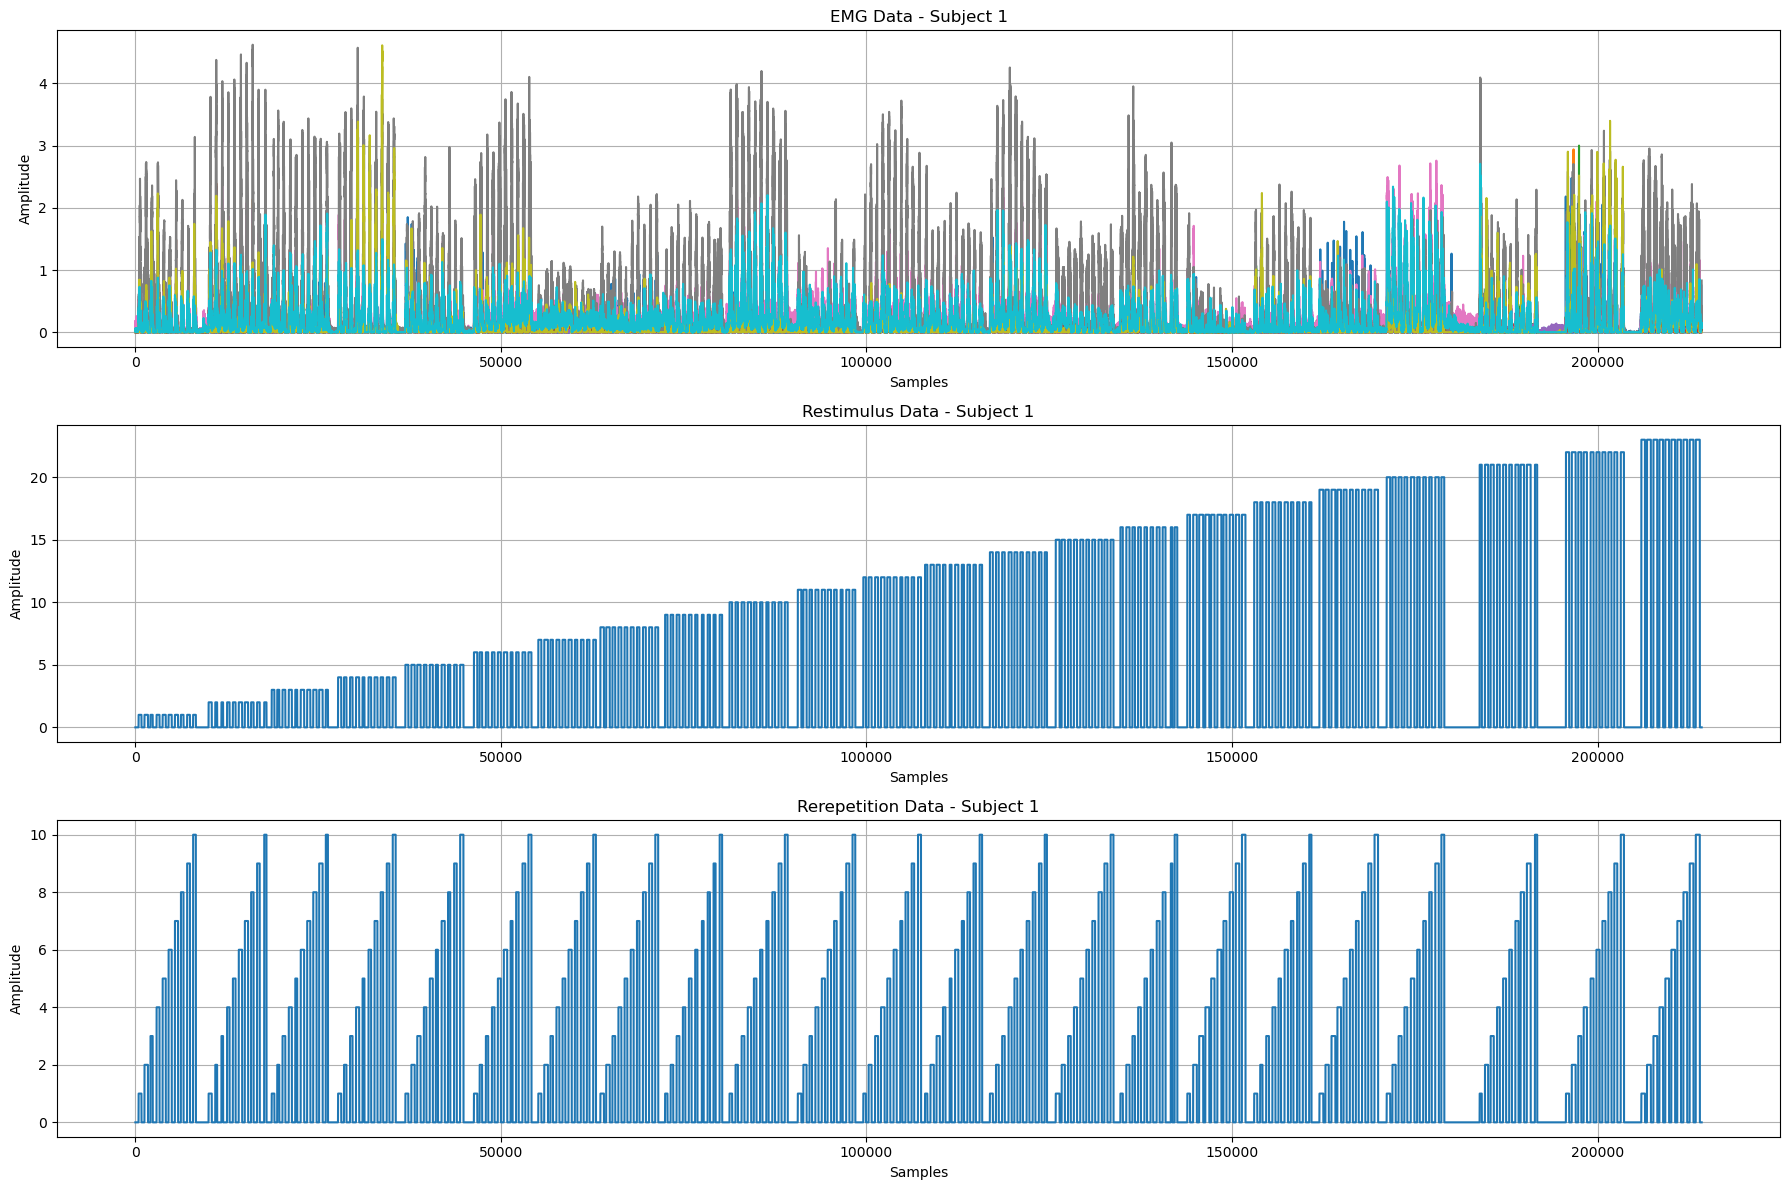

In [51]:
plt.figure(figsize=(18, 12))

# Primer subplot para emg_s1
plt.subplot(3, 1, 1)
plt.plot(emg)  # Muestra los primeros 10,000 puntos
plt.title("EMG Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# restimulus_s1
plt.subplot(3, 1, 2)
plt.plot(restimulus)  # Muestra los primeros 10,000 puntos
plt.title("Restimulus Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# rerepetition_s1
plt.subplot(3, 1, 3)
plt.plot(rerepetition)  # Muestra los primeros 10,000 puntos
plt.title("Rerepetition Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

#### 3.2.6. Almacenamiento de los datos

Almacenamiento de las matrices de datos de cada usuario como matrices numpy para tareas de procesamiento posterior.

In [53]:
# Crear un directorio para guardar las matrices si no existe
output_dir = RAW_DATA_DIR_NPY

# Guardar cada matriz numpy en un archivo separado
for idx, matrix in enumerate(data_ex3):
    file_path = os.path.join(output_dir, f"data_ex3_subject_{idx + 1}.npy")
    np.save(file_path, matrix)
    print(f"Matriz del sujeto {idx + 1} guardada en: {file_path}")

Matriz del sujeto 1 guardada en: ./local/data/raw_numpy\data_ex3_subject_1.npy
Matriz del sujeto 2 guardada en: ./local/data/raw_numpy\data_ex3_subject_2.npy
Matriz del sujeto 3 guardada en: ./local/data/raw_numpy\data_ex3_subject_3.npy
Matriz del sujeto 4 guardada en: ./local/data/raw_numpy\data_ex3_subject_4.npy
Matriz del sujeto 5 guardada en: ./local/data/raw_numpy\data_ex3_subject_5.npy
Matriz del sujeto 6 guardada en: ./local/data/raw_numpy\data_ex3_subject_6.npy
Matriz del sujeto 7 guardada en: ./local/data/raw_numpy\data_ex3_subject_7.npy
Matriz del sujeto 8 guardada en: ./local/data/raw_numpy\data_ex3_subject_8.npy
Matriz del sujeto 9 guardada en: ./local/data/raw_numpy\data_ex3_subject_9.npy
Matriz del sujeto 10 guardada en: ./local/data/raw_numpy\data_ex3_subject_10.npy
Matriz del sujeto 11 guardada en: ./local/data/raw_numpy\data_ex3_subject_11.npy
Matriz del sujeto 12 guardada en: ./local/data/raw_numpy\data_ex3_subject_12.npy
Matriz del sujeto 13 guardada en: ./local/data

## 4. Conclusiones

Al finalizar este notebook se logro.
* Seleccionar de los datos de electromiografia superficial del ejercicio 3.
* Guardat todos los datos con las del ejercicio 3 como matrices de numpy para procesamiento posterior.